In [214]:
# Import libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [215]:
df= pd.read_csv("Cleaned_healthcare_dataset.csv")

In [216]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby Jackson,30,Male,B-,Cancer,1/31/2024,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,2/2/2024,Paracetamol,Normal
1,Leslie Terry,62,Male,A+,Obesity,8/20/2019,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,8/26/2019,Ibuprofen,Inconclusive
2,Danny Smith,76,Female,A-,Obesity,9/22/2022,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,10/7/2022,Aspirin,Normal
3,Andrew Watts,28,Female,O+,Diabetes,11/18/2020,Kevin Wells,Hernandez Rogers and Vang,Medicare,37909.78241,450,Elective,12/18/2020,Ibuprofen,Abnormal
4,Adrienne Bell,43,Female,AB+,Cancer,9/19/2022,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,10/9/2022,Penicillin,Abnormal


In [217]:
df.info()

# 15 columns and 997 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                997 non-null    object 
 1   Age                 997 non-null    int64  
 2   Gender              997 non-null    object 
 3   Blood Type          997 non-null    object 
 4   Medical Condition   997 non-null    object 
 5   Date of Admission   997 non-null    object 
 6   Doctor              997 non-null    object 
 7   Hospital            997 non-null    object 
 8   Insurance Provider  997 non-null    object 
 9   Billing Amount      997 non-null    float64
 10  Room Number         997 non-null    int64  
 11  Admission Type      997 non-null    object 
 12  Discharge Date      997 non-null    object 
 13  Medication          997 non-null    object 
 14  Test Results        997 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 117.0+ 

# Some EDA:

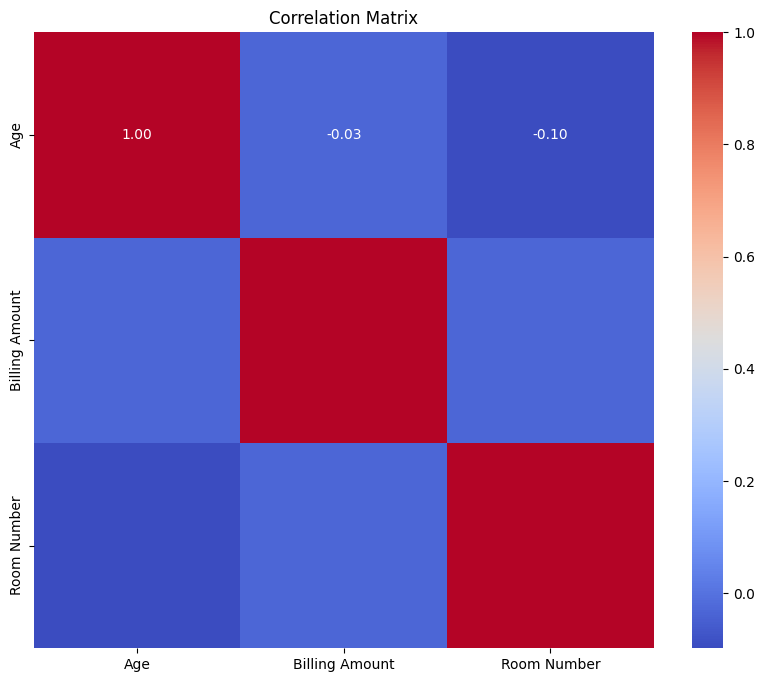

In [218]:
# Only include numeric columns for correlation otherwise I get error
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# No highly correlated features. Excellent.


### Visualising outliers using box plot:

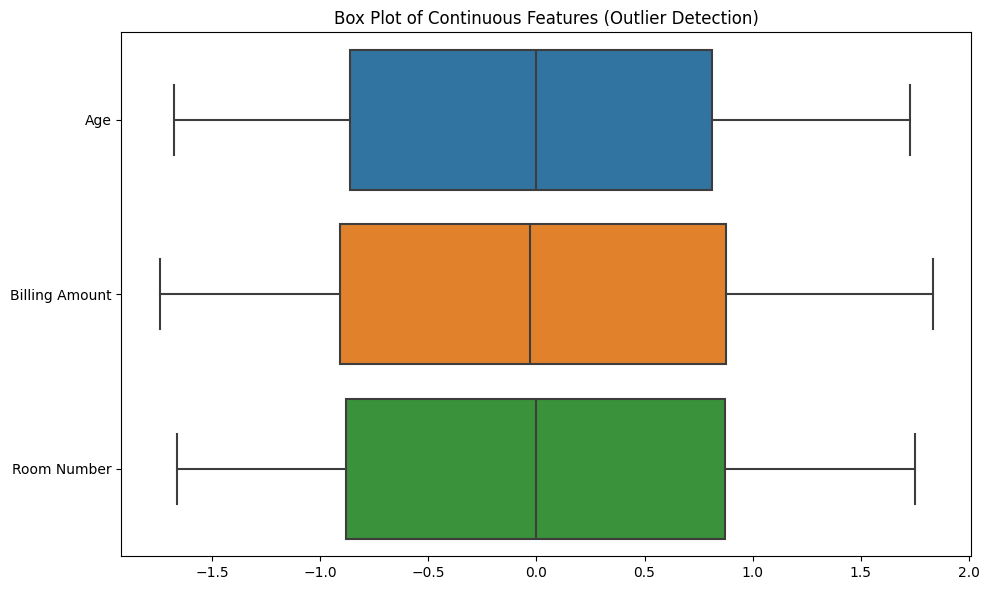

In [178]:
# only relevant continuous variables
numeric_cols = ['Age', 'Billing Amount', 'Room Number']  # Add others if needed

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title("Box Plot of Continuous Features (Outlier Detection)")
plt.tight_layout()
plt.show()

# no extreme outliers (values outside the whiskers)

### More interesting visuals:

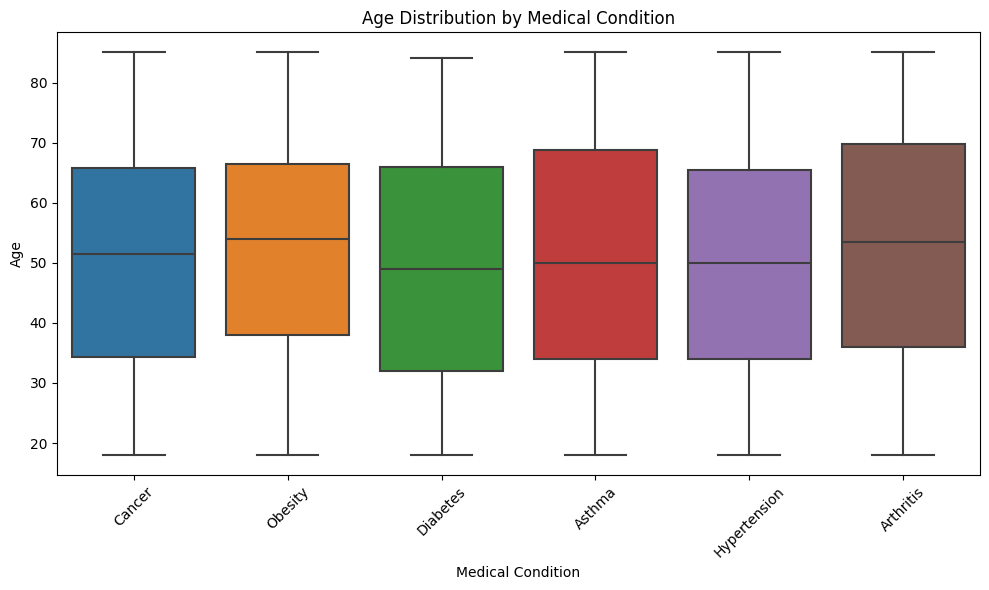

In [222]:
# Ages vs their medical condiition
# Arthritis has highest median age, diabetes lowest

plt.figure(figsize=(10, 6))
sns.boxplot(x='Medical Condition', y='Age', data=df)  # assuming df_raw is your unencoded data
plt.title('Age Distribution by Medical Condition')
plt.xlabel('Medical Condition')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

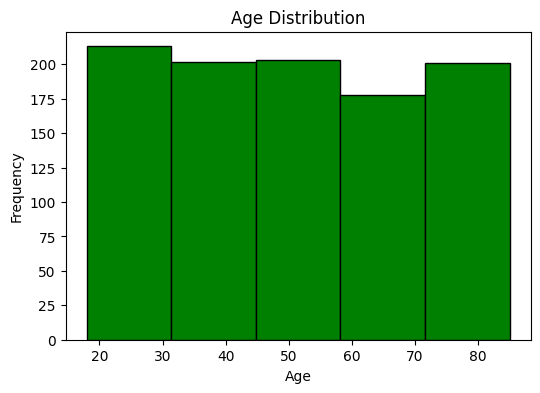

In [213]:
# Age distribution
plt.figure(figsize=(6, 4))
plt.hist(df['Age'], bins=5, color='green', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


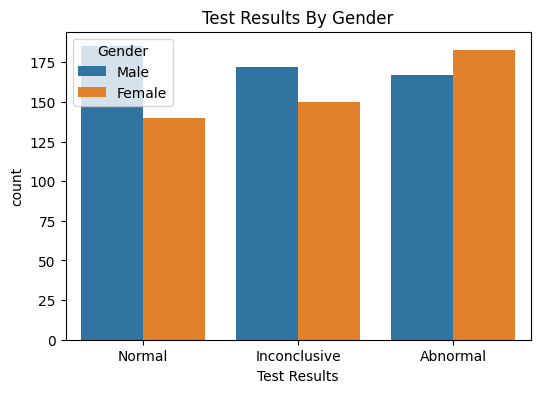

In [223]:
# Gender test results analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='Test Results', hue='Gender', data=df)
plt.title('Test Results By Gender')
plt.show()

# Data preprocessing:

First let us encode.

Which categorical variables must I encode? My goal is to make a predictive models (predicting the test results), and so first of all let us remove 'name', 'doctor', and 'hospital'. They have high cardinality, meaning many unique values, and therefore are not useful for our model. High cardinality can lead to increased sparsity and overfitting. I will encode the rest of the categorical variables with low cardinality.

Should we use one-hot encoding or label encoding? 

Ordinal - Label encoding
Not ordinal - One hot encoding

In this case all categorical variables that we will encode are non-ordinal except admission type and test results. 

In [224]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


df['Admission Type'] = label_encoder.fit_transform(df['Admission Type'])
df['Test Results'] = label_encoder.fit_transform(df['Test Results'])

df = pd.get_dummies(df, columns=['Gender', 'Blood Type', 'Medical Condition',
                                 'Insurance Provider', 'Medication'], 
                    drop_first=False, dtype=int)


In [225]:
df.head()
# looks good

,Name,Age,Date of Admission,Doctor,Hospital,Billing Amount,Room Number,Admission Type,Discharge Date,Test Results,...,Insurance Provider_Aetna,Insurance Provider_Blue Cross,Insurance Provider_Cigna,Insurance Provider_Medicare,Insurance Provider_UnitedHealthcare,Medication_Aspirin,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin
0,Bobby Jackson,30,1/31/2024,Matthew Smith,Sons and Miller,18856.28131,328,2,2/2/2024,2,...,0,1,0,0,0,0,0,0,1,0
1,Leslie Terry,62,8/20/2019,Samantha Davies,Kim Inc,33643.32729,265,1,8/26/2019,1,...,0,0,0,1,0,0,1,0,0,0
2,Danny Smith,76,9/22/2022,Tiffany Mitchell,Cook PLC,27955.09608,205,1,10/7/2022,2,...,1,0,0,0,0,1,0,0,0,0
3,Andrew Watts,28,11/18/2020,Kevin Wells,Hernandez Rogers and Vang,37909.78241,450,0,12/18/2020,0,...,0,0,0,1,0,0,1,0,0,0
4,Adrienne Bell,43,9/19/2022,Kathleen Hanna,White-White,14238.31781,458,2,10/9/2022,0,...,1,0,0,0,0,0,0,0,0,1


### Let us scale the data

We can for example normalise or standardise. Deciding to scale or not to scale the data depends on the model chosen. Here I will use a neural network, meaning scaling is beneficial os that our numerical fetaures are on a similar scale, since right now they vary a lot (billing amount in the tens of thousands while ages are all under 100).

In [226]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['Age'] = scaler.fit_transform(df[['Age']])
df['Billing Amount'] = scaler.fit_transform(df[['Billing Amount']])
df['Room Number'] = scaler.fit_transform(df[['Room Number']])


### Feature Engineering

We do not have many features or rows of data, we need not worry about the model dimensions needing to be reduced. We ca use all features and rows as they are.

# Modelling:

First split the data, then build and run model.

In [227]:
X = df.drop(columns=['Test Results', 'Name', 'Doctor', 'Hospital', 'Date of Admission', 'Discharge Date'])
y = df[['Test Results']]


In [228]:
# 20% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
# # Creating a feedforward neural network using Sequential(), with layers in sequence one after another in one direction with no feedback

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer, using dense for a fully connected layer
    # Relu activation fucntion to introduce non linearity into the network so model can learn complex patterns
    Dense(16, activation='relu'),  # Hidden layer
    Dense(3, activation='softmax')  # Output layer (3 classes). Softmax since multi class. If binary classification, sigmoid could be used here with one output neuron, and below binary cross entropy

])



C:\Users\Faisal\Downloads\ANACONDA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [230]:
# compiling

model.compile(optimizer='adam',  # optimiser to adapt learning rate for each parameter
              loss='sparse_categorical_crossentropy',  # for integer target variable
              metrics=['accuracy'])

In [231]:
# Train the model

#model processes 16 samples before updating weights

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=200,
    batch_size= 128,
    verbose=1,
    validation_split=0.2,  # This uses 20% of traininig set for val. So, 64% train, 16% val, 20% test
    callbacks=[early_stop]
)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3426 - loss: 1.1339 - val_accuracy: 0.3875 - val_loss: 1.0911
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3416 - loss: 1.1157 - val_accuracy: 0.3750 - val_loss: 1.0897
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3342 - loss: 1.1137 - val_accuracy: 0.3688 - val_loss: 1.0914
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3576 - loss: 1.1015 - val_accuracy: 0.3750 - val_loss: 1.0932
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3675 - loss: 1.0970 - val_accuracy: 0.3750 - val_loss: 1.0947
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3787 - loss: 1.0928 - val_accuracy: 0.3688 - val_loss: 1.0962
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3760 - loss: 1.0898 - val_accuracy: 0.3688 - val_loss: 1.0975
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3898 - loss: 1.0811 - val_accuracy: 0.3875 - val_loss: 1

# Evaluate model:

In [232]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [233]:
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

# bad performance, as explained below it might be because features are not correlated enough to this target variable/no storng relationships

Accuracy: 0.37


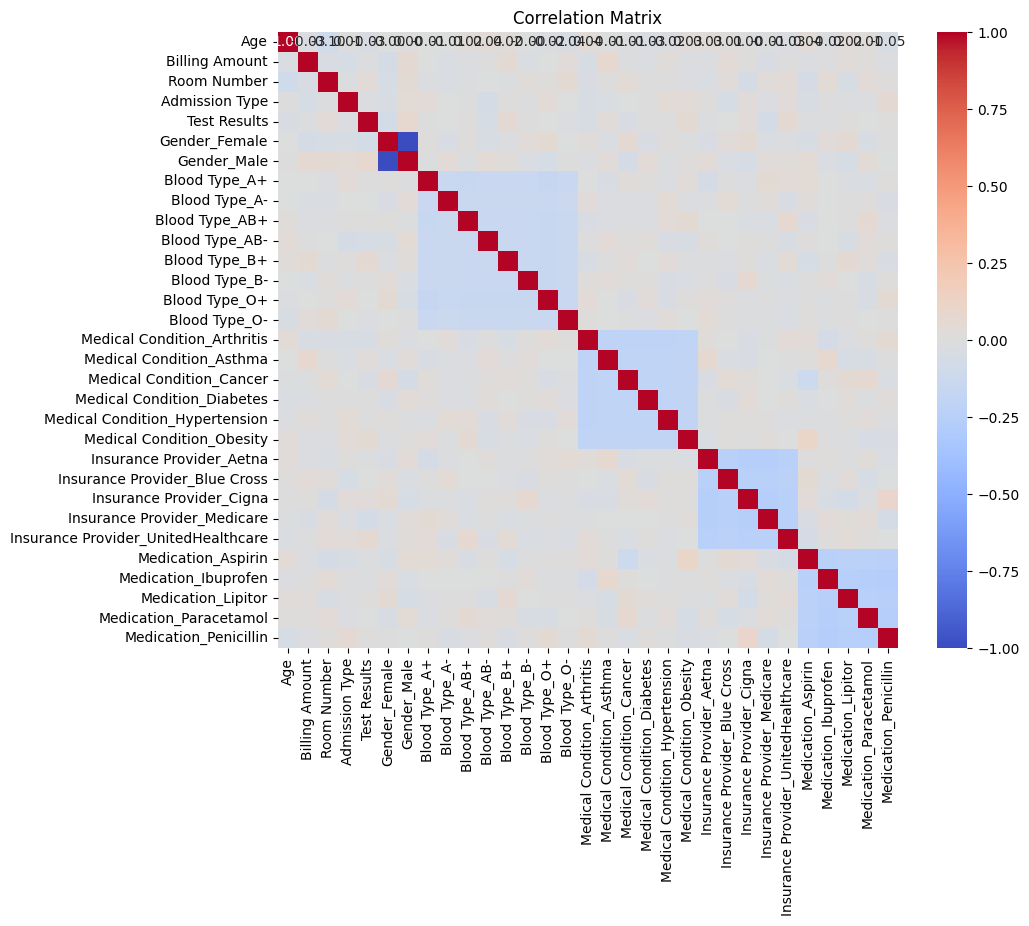

In [234]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# From the correlations to the target variable 'Test Result', we can see that no variables are highly correlated to this target variable
# That is one of the reasons will be difficult to train this model to predict this variable